In [1]:
%run ../src/game.py
%run ../src/ipd.py
%run ../src/strategies.py
%run ../src/tools.py
dip =[(3,3),(0,5),(5,0),(1,1)]   # Dilemme du prisonnier



# Evaluation par synthèse de sous-classes

Les compétitions écologiques offrent un outil de mesure assez fiable de la robustesse d'une stratégies, mais encore insuffisant. Il se peut par exemple que certaines stratégies se sacrifient pour d'autres dans un schema *maitre-esclave*. Avoir une synthèse de centaines voir de milliers de compétitions écologiques dans lesquelles on a enlevé certaines stratégies mesure sans doute une meilleure robustesse. L'une des idées les plus simples consiste à calculer les n compétitions possibles que l'on peut faire en enlevant 1 stratégie à un ensemble de n stratégies. On appelle cette technique la technique des sous-classes.
Nous définissions ici 3 fonctions permettant de réaliser ces sous-classes.
- `subclasses(bag, n)` qui évalue tous les sous ensembles possibles de taille n dans la bage
- `subclassesWithOneStrat(bag, n, strat)` qui évalue Strat dans tous les sous ensembles possibles de taille n dans la bage en ajoutant systématiquement la stratégie strat
- `subclassesRandomWithOneStrat(p, bag, n, Strat)` qui réalise p competitions de n strategies choisies au hasard dans la bage dans lesquelles on rajoute systématiquement Strat

Les évaluations réalisées dans ces fonctions sont des compétitions écologiques.

Ces fonctions renvoient à la fin un tableau avec pour chaque stratégie, sa meilleure place, sa pire place, sa moyenne et son écart-type.

#### Un cas simple : toutes les compétitions de 3 stratégies parmi les classiques

In [30]:
All_C = Periodic('C')
All_D = Periodic('D')
bag = [All_C, All_D, Tft(), Spiteful(), Gradual(), SoftMajority(), HardMajority()]
subClasses(bag, 3)

          BestRank  WorstRank   RankAvg   RankStd
tft            1.0        2.0  1.133333  0.351866
softmajo       1.0        2.0  1.133333  0.351866
spiteful       1.0        2.0  1.266667  0.457738
gradual        1.0        2.0  1.333333  0.487950
per_C          1.0        3.0  1.400000  0.632456
per_D          1.0        3.0  2.533333  0.743223
hardmajo       2.0        3.0  2.666667  0.487950


#### Un cas plus volumineux : toutes les stratégies Mem(1,1) avec une stratégie en moins à chaque fois
Sachant qu'il y a 32 `mem(1,1)` cette opération réalise donc 32 compétitions de 31 stratégie. Notez que dans le cas de cette méthode, toutes les stratégies sont présentes (et absentes) exactement le même nombre de fois.


In [19]:
import time
before = time.time()
bag = getAllMemory(1,1)
subClasses(bag, len(bag)-1)
after = time.time()
print("Time : {}".format(after-before))

       BestRank  WorstRank   RankAvg   RankStd
CCDDD       1.0        1.0  1.000000  0.000000
CCDCD       1.0        2.0  1.967742  0.179605
CCDDC       2.0        3.0  2.935484  0.249731
CCDCC       2.0        4.0  3.838710  0.454369
CCCCC       2.0        5.0  4.806452  0.601074
CCCCD       2.0        5.0  4.806452  0.601074
CCCDC       2.0        5.0  4.806452  0.601074
CCCDD       2.0        5.0  4.806452  0.601074
CDCCC       2.0        5.0  4.806452  0.601074
CDCCD       2.0        5.0  4.806452  0.601074
CDCDC       2.0        5.0  4.806452  0.601074
CDCDD       2.0        5.0  4.806452  0.601074
CDDCC       2.0        5.0  4.806452  0.601074
CDDCD       2.0        5.0  4.806452  0.601074
CDDDC       2.0        5.0  4.806452  0.601074
CDDDD       2.0        5.0  4.806452  0.601074
DCCCC       2.0        5.0  4.806452  0.601074
DCCCD       2.0        5.0  4.806452  0.601074
DCCDC       2.0        5.0  4.806452  0.601074
DCCDD       2.0        5.0  4.806452  0.601074
DCDCC       2

#### Test de la stratégie Spiteful avec tous les triplets de classiques
Dans les cas des deux méthodes `subClassesWithOneStrat` seule la stratégie passée en paramètre participe à toutes les sous-classes (faisable pour des ensembles pas trop volumineux genre `mem(1,1)`). Dans la première elle participe à la totalité des sous-classes tandis qu'avec `subClassesRandomWithOneStrat` elle participe à un nombre fixé de sous classes de même taille mais prises aléatoirement (utilisable dans de gros ensembles comme `mem(2,2)`).

In [ ]:
All_C = Periodic('C')
All_D = Periodic('D')
bag = [All_C, All_D, Tft(), Gradual(), SoftMajority(), HardMajority()]
res  = subClassesWithOneStrat(bag, 3, Spiteful())
#Pour afficher le tableau en entier : 
#res = subClassesWithOneStrat(bag, 3, Spiteful(), True)

Il est à noter que les objets `subClassesWithOneStrat` et `subClassesRandomWithOneStrat` conservent le 
meilleur et le pire des tournois pour la stratégie `strat`
Au moment de l'affichage du classement des sous-classes il est de ce fait possible d'afficher l'ensemble de stratégies qui a été favorable ou défavorable à la stratégie `Strat`.

In [ ]:
meilleureComp, pireComp, strategy = res
print("La meilleure competition pour la stratégie "+strategy.name +" est : ")
for strat in meilleureComp :
    print(strat.name)

#### 100 experiences de 10 stratégies prise au hasard dans mem(2,2) contre Gradual()
Pour les `subclassesRandom`, si une stratégie n'a joué qu'une seule fois alors elle n'a pas d'écart-type (`NaN`); si elle n'a pas joué du tout alors toutes ses valeurs sont à `NaN` dans le tableau

In [32]:
bag = getAllMemory(2,2)
res = subClassesRandomWithOneStrat(100,bag, 10, Gradual())
#Pour afficher le tableau en entier : 
#subClassesRandomWithOneStrat(100, bag, 10, Gradual(), True)


Strategy ranking  : gradual
BestRank     1.000000
WorstRank    6.000000
RankAvg      2.340000
RankStd      1.182533
Name: gradual, dtype: float64


On peut d'ailleurs vérifier la compétition la plus "défavorable" à Gradual 
(comme c'est un choix aléatoire, donc 2 éxécutions ne donneront pas systématiquement le même résultat)

In [ ]:
bestComp, worstComp, strategy = res

In [ ]:
bag = worstComp
e2=Ecological(g,bag)
e2.run()
e2.drawPlot(None,None)
evol=e2.historic
print(evol.iloc[-1])
print(e2.historic.iloc[e2.generation].rank(0, method="min", ascending=False))

## Conception d'un méta-stratégie

Une méta-stratégie est une stratégie composée de plusieurs stratégies. 
Dans un premier temps, chaque stratégie joue pendant n tours et on comptabilise le nombre de points pour chaque stratégie pendant ces n tours.
On choisit ensuite la stratégie qui a le plus de points et on répète ce choix tous les n tours.
Pour écrire une méta-stratégie, on écrit `MetaStrategy(liste des stratégies, n)`

In [2]:
# check of MetaStrategy : the two results should be the same

# with Metastrat
metaStrat = MetaStrategy([Tft()], 5)
bag = getMem(1,1)
res  = subClassesWithOneStrat(bag,len(bag)-1, metaStrat)

# without Metastrat
res  = subClassesWithOneStrat(bag,len(bag)-1, Tft())


Strategy ranking  : metastrat
BestRank     1.000000
WorstRank    2.000000
RankAvg      1.968750
RankStd      0.176777
Name: metastrat, dtype: float64
Strategy ranking  : tft
BestRank     1.000000
WorstRank    2.000000
RankAvg      1.968750
RankStd      0.176777
Name: tft, dtype: float64


In [3]:
# check of MetaStrategy : the two results should be the same (with a Periodic)

metaStrat = MetaStrategy([Periodic("CCD")], 5)
res  = subClassesWithOneStrat(bag,len(bag)-1, metaStrat)

res  = subClassesWithOneStrat(bag,len(bag)-1, Periodic("CCD"))

Strategy ranking  : metastrat
BestRank     2.000000
WorstRank    5.000000
RankAvg      4.812500
RankStd      0.592289
Name: metastrat, dtype: float64
Strategy ranking  : per_CCD
BestRank     2.000000
WorstRank    5.000000
RankAvg      4.812500
RankStd      0.592289
Name: per_CCD, dtype: float64


### Tests de méta-stratégies
On cherche ici la meilleure meta-stratégie contre Memory(1,1) + Gradual.
On fait différents tests durant lesquels on change : 
- les stratégies
- le nombre de tours n.

On utilise pour cela les sous-classes `subClassesWithOneStrat` qui, pour une stratégie particulière (ici, notre meta-stratégie) fait plusieurs compétitions écologiques et mesure le meilleur rang, le pire rang, la rang moyen, et l'écart-type.

In [34]:
metaStrat = MetaStrategy([Tft(), Periodic("C"), Spiteful(), Periodic("CCD")], 5)
bag = getMem(1,1)+[Gradual()]
res  = subClassesWithOneStrat(bag,len(bag)-1, metaStrat, length = 100)



Strategy ranking  : metastrat
BestRank      5.000000
WorstRank    10.000000
RankAvg       7.909091
RankStd       2.067058
Name: metastrat, dtype: float64


In [36]:
metaStrat = MetaStrategy([Tft(), Periodic("C"), Spiteful(), Periodic("CCD")], 4)
bag = getMem(1,1)+[Gradual()]
res  = subClassesWithOneStrat(bag,len(bag)-1, metaStrat, length = 100)


Strategy ranking  : metastrat
BestRank      5.000000
WorstRank    10.000000
RankAvg       7.545455
RankStd       2.078024
Name: metastrat, dtype: float64


In [37]:
metaStrat = MetaStrategy([Tft(), Periodic("C"), Spiteful(), Periodic("CCD")], 3)
bag = getMem(1,1)+[Gradual()]
res  = subClassesWithOneStrat(bag,len(bag)-1, metaStrat, length = 100)


Strategy ranking  : metastrat
BestRank      5.000000
WorstRank    10.000000
RankAvg       7.181818
RankStd       2.053268
Name: metastrat, dtype: float64


In [45]:
metaStrat = MetaStrategy([Tft(), Periodic("C"), Spiteful(), Periodic("CCD")], 2)
bag = getMem(1,1)+[Gradual()]
res  = subClassesWithOneStrat(bag,len(bag)-1, metaStrat, length = 100)


Strategy ranking  : metastrat
BestRank     5.000000
WorstRank    6.000000
RankAvg      5.848485
RankStd      0.364110
Name: metastrat, dtype: float64


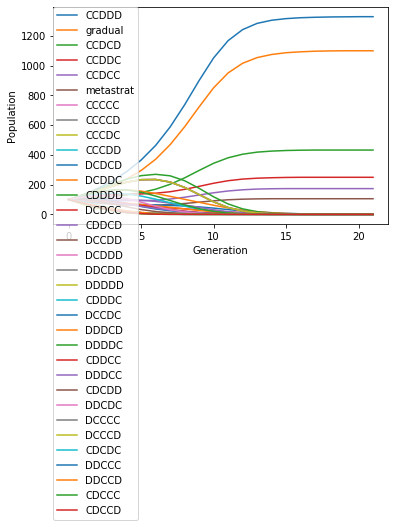

In [6]:
metaStrat = MetaStrategy([Tft(), Periodic("C"), Spiteful(), Periodic("CCD")], 1)
bag = getMem(1,1)+[Gradual()]

# Test avec les sous-classes
# res  = subClassesWithOneStrat(bag,len(bag)-1, metaStrat, length = 100)

# Test avec un tournoi
# t = Tournament(g,[metaStrat]+bag)
# t.run()
# print(t.matrix)
# print(t.matrix['Total'])

# Test avec une competition écolo
e = Ecological(g,[metaStrat]+bag)
e.run()
e.drawPlot(None,None)
#print(e.score)

In [35]:
metaStrat = MetaStrategy([Tft(), Spiteful(), Gradual()], 3)
bag = getMem(1,1)+[Gradual()]
res  = subClassesWithOneStrat(bag,len(bag)-1, metaStrat, length = 100)

Strategy ranking  : metastrat
BestRank      5.000000
WorstRank    10.000000
RankAvg       9.363636
RankStd       1.453835
Name: metastrat, dtype: float64


Conclusion : La meilleure méta-stratégie que l'on a trouvé est la Méta-stratégie composée des stratégies Tft(), Periodic('C'), Spiteful(), Periodic('CCD') avec un n=2 ou n=1.
Verifions maintenant si cette séquence de stratégies est optimal en testant toutes les séquences possibles

In [42]:
bag = getMem(1,1)+[Gradual()]
all = itertools.permutations([Tft(), Periodic("C"), Spiteful(), Periodic("CCD")])
for a in all : 
    print("Ordre")
    for strat in a : 
        print(strat.name)
    metaStrat = MetaStrategy(a, 2)
    res  = subClassesWithOneStrat(bag,len(bag)-1, metaStrat, length = 100)
    

Ordre
tft
per_C
spiteful
per_CCD
Strategy ranking  : metastrat
BestRank     5.000000
WorstRank    6.000000
RankAvg      5.848485
RankStd      0.364110
Name: metastrat, dtype: float64
Ordre
tft
per_C
per_CCD
spiteful
Strategy ranking  : metastrat
BestRank     5.000000
WorstRank    6.000000
RankAvg      5.848485
RankStd      0.364110
Name: metastrat, dtype: float64
Ordre
tft
spiteful
per_C
per_CCD
Strategy ranking  : metastrat
BestRank     5.000000
WorstRank    6.000000
RankAvg      5.848485
RankStd      0.364110
Name: metastrat, dtype: float64
Ordre
tft
spiteful
per_CCD
per_C
Strategy ranking  : metastrat
BestRank     5.000000
WorstRank    6.000000
RankAvg      5.848485
RankStd      0.364110
Name: metastrat, dtype: float64
Ordre
tft
per_CCD
per_C
spiteful
Strategy ranking  : metastrat
BestRank     5.000000
WorstRank    6.000000
RankAvg      5.848485
RankStd      0.364110
Name: metastrat, dtype: float64
Ordre
tft
per_CCD
spiteful
per_C
Strategy ranking  : metastrat
BestRank     5.000000


Après cette vérification les séquences de stratégies qui fournissent les moins bons résultats sont les séquences commençant par Periodic('CCD'), toutes les autres fournissent un meilleur résultat.


## Tests d'équivalence de stratégies
Dans cette section on cherche à savoir si des stratégies sont équivalentes au regard d'autres stratégies lors de tournois. 


`testEquivUnit` teste l'équivalence d'un couple de strategies `strategies` contre une stratégie `opponent` de comparaison pendant `length` tours de tournois. Elle renvoie un booléen : équivalent ou pas.

In [9]:
def testEquivUnit(strategies, opponent, length):
    res = []
    for strat in strategies :
        t = Tournament(g, [opponent, strat], length)
        t.run()
        s = t.matrix[strat.name].to_string()
        res += [tuple([int(i) for i in s.split() if i.isdigit()])] 
        #print(res)
    return len(set(res)) == 1

print(testEquivUnit([Periodic('C'), Periodic('C')], Periodic('CCD'), 100))
print(testEquivUnit([Periodic('C'), Periodic('D')], Periodic('CCD'), 100))
print(testEquivUnit([Periodic('CCCD'), Periodic('CCCC')], Periodic('CCD'), 3))
print(testEquivUnit([Tft(), Spiteful()]  , Periodic("CCDCD"), 100))
print(testEquivUnit([Tft(), Mem(0,1,"cCD")],  Periodic("CCDCD"), 100))
print("")
# Verification des quatres stratégies
print(testEquivUnit([Mem(1,2,"DDDCDDDDDC"), Mem(1,2,"DDCCDDDDDC")], Periodic('C'), 10))
print(testEquivUnit([Mem(1,2,"DDDCDDDDDC"), Mem(1,2,"DDCDDDDDDC")], Periodic('C'), 10))
print(testEquivUnit([Mem(1,2,"DDDCDDDDDC"), Mem(1,2,"DDDDDDDDDC")], Periodic('C'), 10))
print(testEquivUnit([Mem(1,2,"DDCDDDDDDC"),Mem(1,2,"DDDDDDDDDC")], Periodic('CD'), 10))

True
False
True
False
True

False
False
False
True


L'équivalence de deux programmes est indécidable. Il n'y a donc pas de test parfait. Dans un premier temps, pour comparer 2 stratégies fixées, on les fait jouer contre une stratégie de référence. Evidemment selon la complexité de cette stratégie, le test est plus ou moins pertinent

Montre une comparaison de 2 stratégies face à Periodic("C") qui indique qu'elles sont équivalentes alors qu'elles ne le sont pas. (Tft + Spiteful)
Refaire le meme test face à Periodic("CCD"). On constate que le test est plus pertinent.
Mais il n'est néanmoins pas parfait. 
Comment on montre qu'il n'est pas parfait ????


Tout ça, amène au testMultiple


Juste après testMultiple il faut indiquer que ce test est plus robuste, mais toujours pas parfait. Par exemple trouver 2 stratégies qui sont différentes, mais qui face à mem(1,1) donnent la même chose


In [ ]:
s2 = Periodic("CD")
s1 = Mem(1,2,"DDCCDDDDDC")
eco = Ecological(g, [s1, s2])
eco.run()
print(eco.scores)


s1 = Mem(1,2,"DDDCDDDDDC")
eco = Ecological(g, [s1, s2])
eco.run()
print(eco.scores)


s1 = Mem(1,2,"DDCDDDDDDC")
eco = Ecological(g, [s1, s2])
eco.run()
print(eco.scores)


s1 = Mem(1,2,"DDDDDDDDDC")
eco = Ecological(g, [s1, s2])
eco.run()
print(eco.scores)


`testEquivMultiple` teste l'équivalence d'un couple de strategies `strategies` contre une liste de
stratégies `opponents` de comparaison pendant `length` tours de tournois. 
Elle renvoie un booléen : équivalent ou pas.

In [8]:
def testEquivMultiple(strategies, opponents, length):
    for opponent in opponents : 
        equiv = testEquivUnit(strategies, opponent, length)
        if equiv == False :
            return False
    return True

print(testEquivMultiple([Periodic('C'), Periodic('C')], [Periodic('CCD'), Periodic('DDC')], 10))
print(testEquivMultiple([Periodic('C'), Periodic('D')],[Periodic('CCD'), Periodic('DDC')], 10))
print(testEquivMultiple([Periodic('CCCD'), Periodic('CCCC')],[Periodic('CCD'), Periodic('DDC')], 3))
print(testEquivMultiple([Tft(), Spiteful()],getMem(1,1), 10))
print("")
# Verification des quatres stratégies
print(testEquivMultiple([Mem(1,2,"DDDCDDDDDC"), Mem(1,2,"DDCCDDDDDC")], getMem(1,1), 100))
print(testEquivMultiple([Mem(1,2,"DDDCDDDDDC"), Mem(1,2,"DDCDDDDDDC")], getMem(1,1), 100))
print(testEquivMultiple([Mem(1,2,"DDDCDDDDDC"), Mem(1,2,"DDDDDDDDDC")], getMem(1,1), 100))
print(testEquivMultiple([Mem(1,2,"DDCDDDDDDC"),Mem(1,2,"DDDDDDDDDC")], getMem(1,1), 100))


True
False
True
False

False
False
False
True


`classesEquiv(l, opponents, length)` fait un test multiple pour tous les
couples possibles dans `l` contre `opponents`  et renvoie dans une map les classes d'équivalence.
Par exemple si on a strat1 équivalente à strat2 et strat3 qui n'a pas d'quivalence, la fonction va renvoyer dans une map : {
- strat1 : [strat2]
- strat3 : []
}

In [11]:
def classesEquiv(l, opponents, length):
    m = dict()
    #print(l)
    while len(l) > 0 :
        m[l[0]] = []
        liste_tmp = l[1:]
        #print(liste_tmp)
        ind = []
        for j in range(len(liste_tmp)):
            #print(l[0])
            #print(l[j + 1])
            if testEquivMultiple([l[0], l[j + 1]], opponents, length):
               # print("ok")
                m[l[0]] += [l[j + 1]]
                ind += [j + 1]
        #print(ind)
        for index in ind:
            #print(index)
            del l[index]
        del l[0]
        #print(l)
    return m


            
ce = classesEquiv([Tft(), Tft()], [Periodic('CCD'), Periodic('DDC')], 10))
names = [s.name for s : ce]
print(names)

print(classesEquiv([Gradual(), Tft()],[Periodic('CCD'), Periodic('DDC')], 10))
print(classesEquiv([Tft(), Tft(), Periodic('D')], [Periodic('C')], 1))
L = [Tft(), Spiteful(), Mem(0,1,"cCD"),  Mem(1,1,"cCDDD"), Periodic("CDC") ]
print(classesEquiv(L, [Periodic('CCD'), Periodic('DDC')], 10))

        
            

SyntaxError: invalid syntax (<ipython-input-11-fefc7b309ed6>, line 26)

`simplify` est la fonction simplificatrice. Elle simplifie la liste de stratégies `l` en les testant contre les stratégies `opponents` pendant `length` tours.
Elle renvoie un couple de valeurs : 
- la liste simplifiée avec toutes les stratégies n'ayant pas d'équivalence entre elles
- la map des stratégies équivalentes

In [12]:
def simplify(l, opponents, length):
    scores = dict()
    for strat in l :
        t = Tournament(g, opponents + [strat], length)
        t.run()
        res = t.matrix['Total'][strat.name]
        if res not in scores :
            scores[res] = [strat]
        else : 
            scores[res] += [strat]
    #print(scores)
    
    simplified = []
    d = dict()
    for item in scores.values():
        if len(item) > 1 :
            res = classesEquiv(item, opponents, length)
            for it in res.keys():
                if len(res[it]) > 0 :
                    d[it] = res[it]
            simplified += res.keys()
        else : 
            simplified += item
   
    return simplified, d
        

print(simplify([Tft(), Tft(), Periodic('D')], [Periodic('C')], 1))
print("")
print(simplify([Tft(), SoftMajority()], [Periodic("DCD")], 10))
print("")
print(simplify([Tft(), Spiteful(), Mem(0,1,"cCD"),  Mem(1,1,"cCDDD"), Periodic("CDC") ], [Periodic('CCD'), Periodic('DDC')] , 10))


        
    

([<__main__.Tft object at 0x7fb3c80cd0f0>, <__main__.Periodic object at 0x7fb3c80cd4a8>], {<__main__.Tft object at 0x7fb3c80cd0f0>: [<__main__.Tft object at 0x7fb3c80cdda0>]})

([<__main__.Tft object at 0x7fb3c801b2b0>, <__main__.SoftMajority object at 0x7fb3c80cd0f0>], {})

([<__main__.Tft object at 0x7fb3c801b2b0>, <__main__.Spiteful object at 0x7fb3c80cd0f0>, <__main__.Periodic object at 0x7fb3c80cd7f0>], {<__main__.Tft object at 0x7fb3c801b2b0>: [<strategies.Mem object at 0x7fb3c80cd518>], <__main__.Spiteful object at 0x7fb3c80cd0f0>: [<strategies.Mem object at 0x7fb3c80cd588>]})


Vérification d'équivalences de quatres stratégies

In [26]:
s2 = Periodic("CD")
s1 = Mem(1,2,"DDCCDDDDDC")
t = Tournament(g, [s1, s2])
t.run()
print(t.matrix)


s1 = Mem(1,2,"DDDCDDDDDC")
t = Tournament(g, [s1, s2])
t.run()
print(t.matrix)

s1 = Mem(1,2,"DDCDDDDDDC")
t = Tournament(g, [s1, s2])
t.run()
print(t.matrix)


s1 = Mem(1,2,"DDDDDDDDDC")
t = Tournament(g, [s1, s2])
t.run()
print(t.matrix)



            DDCCDDDDDC  per_CD  Total
DDCCDDDDDC        2996    3000   5996
per_CD             500    2000   2500
            DDDCDDDDDC  per_CD  Total
DDDCDDDDDC        2000    3000   5000
per_CD             500    2000   2500
            DDCDDDDDDC  per_CD  Total
DDCDDDDDDC        1666    3000   4666
per_CD             500    2000   2500
            DDDDDDDDDC  per_CD  Total
DDDDDDDDDC        1666    3000   4666
per_CD             500    2000   2500


On constate que deux d'entre elles sont équivalentes, regardons si classesEquiv nous confirment bien qu'une stratégie a été simplifiée. (La longueur du résultat devrait être trois car 4 stratégies - 1 simplifiée)

In [27]:
print(len(classesEquiv([Mem(1,2,"DDCCDDDDDC"),Mem(1,2,"DDCDDDDDDC"),Mem(1,2,"DDDCDDDDDC"),Mem(1,2,"DDDDDDDDDC")], [Periodic("CD")],10)))

3


In [13]:
Mem11 = getMem(1,1)
Mem12 = getMem(1,2)
Mem21 = getMem(2,1)
Mem22 = getMem(2,2)

# res11 = classesEquiv(Mem11, [Periodic('CCD'), Periodic('DDC')], 10)
# res12 = classesEquiv(Mem12, [Periodic('CCD'), Periodic('DDC')], 10)
# res21 = classesEquiv(Mem21, [Periodic('CCD'), Periodic('DDC')], 10)
#res22 = classesEquiv(Mem22, [Periodic('CCD'), Periodic('DDC')], 100)

tab = pd.DataFrame(
        np.nan, ["Mem 1 1", "Mem 1 2", "Mem 2 1", "Mem 2 2"], ["All strategies", "After simplify"]
    )
tab.at["Mem 1 1", "All strategies" ] = len(Mem11)
tab.at["Mem 1 2", "All strategies" ] = len(Mem12)
tab.at["Mem 2 1", "All strategies" ] = len(Mem21)
tab.at["Mem 2 2", "All strategies" ] = len(Mem22)
# tab.at["Mem 1 1", "After simplify" ] = len(res11)
# tab.at["Mem 1 2", "After simplify" ] = len(res12)
# tab.at["Mem 2 1", "After simplify" ] = len(res21)
# tab.at["Mem 2 2", "After simplify" ] = len(res22)

tab

,All strategies,After simplify
Mem 1 1,32.0,NaN
Mem 1 2,1024.0,NaN
Mem 2 1,1024.0,NaN
Mem 2 2,262144.0,NaN


## Dilemme spatial (en cours)

In [10]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import random

# Input variables for the board
boardsize = 10   # board will be X by X where X = boardsize
my_board = np.empty((boardsize, boardsize), dtype=float)


# 0 : cooperator
# 1 : new cooperator
# 2 : defector   
# 3 : new defector


# Some helper functions
def init_strategies():
    strategies = np.zeros((boardsize, boardsize), dtype=object)
    for i in range(boardsize) :
        for j in range(boardsize):
            strategies[i, j] = 0
    strategies[5, 5] = 2
    return strategies
    
# Initialize the board with starting positions
# def strategies_to_board(strategies):
#     for i in range(boardsize) :
#         for j in range(boardsize) :
#             if strategies[i, j] == "C":
#                 my_board[i , j] = 0
#             else : 
#                 my_board[i, j] = 1
#     #print("-------------------------")
#     #print(strategies)
#     #print(my_board)
#     #print("--------------------------------")"
#     return my_board
    

# https://github.com/evoplex/model-prisonersDilemma
def update_strategies():
    scores = play()
    strategies = np.copy(update(scores))
    #print(strategies)
    return strategies

def play():
    scores = np.zeros((boardsize, boardsize))
    for i in range(boardsize):
        for j in range(boardsize):
            score = 0
            #cpt = 0
            score += getScore(strategies, i, j, i, j)
            if i >= 0 and j >= 0:
                score += getScore(strategies, i, j, i-1, j-1)
                #cpt += 1
            if j >= 0:
                score += getScore(strategies, i, j, i, j-1)
                #cpt += 1
            if i >= 0 :
                score += getScore(strategies, i, j, i-1, j)
                #cpt += 1
            if i < boardsize - 1 and j < boardsize - 1 :
                score += getScore(strategies, i, j, i+1, j+1)
                #cpt += 1
            if i < boardsize - 1 :
                score += getScore(strategies, i, j, i+1, j)
                #cpt += 1
            if j < boardsize -1 :
                score += getScore(strategies, i, j, i, j+1)
                #cpt += 1
            if i < boardsize - 1 and j >= 0:
                score += getScore(strategies, i, j, i+1, j-1)
                #cpt += 1
            if i >= 0 and j < boardsize - 1 :
                score += getScore(strategies, i, j, i-1, j+1)
                #cpt += 1
            scores[i][j] = score
    #print(scores)
    return scores

def update(scores):
    #print(scores)
    new_strategies = np.zeros((boardsize, boardsize), dtype=object)
    for i in range(boardsize):
        for j in range(boardsize):
            best = scores[i][j]
            ind_i = i 
            ind_j = j
            if i >= 0 and j >= 0:
                if scores[i-1][j-1] > best :
                    best = scores[i-1][j-1]
                    ind_i = i - 1
                    ind_j = j - 1
            if j >= 0:
                if scores[i][j-1] > best :
                    best = scores[i][j-1]
                    ind_i = i 
                    ind_j = j - 1
            if i >= 0 :
                if scores[i-1][j] > best :
                    best = scores[i-1][j]
                    ind_i = i - 1
                    ind_j = j 
            if i < boardsize - 1  and j < boardsize - 1 :
                if scores[i+1][j+1] > best :
                    best = scores[i+1][j+1]
                    ind_i = i + 1
                    ind_j = j + 1
            if i < boardsize - 1:
                if scores[i+1][j] > best :
                    best = scores[i+1][j]
                    ind_i = i + 1
                    ind_j = j 
            if j < boardsize - 1:
                if scores[i][j+1] > best :
                    best = scores[i][j+1]
                    ind_i = i 
                    ind_j = j + 1
            if i < boardsize - 1 and j >= 0:
                if scores[i+1][j-1] > best :
                    best = scores[i+1][j-1]
                    ind_i = i + 1
                    ind_j = j - 1
            if i >= 0 and j < boardsize - 1:
                if scores[i-1][j+1] > best :
                    best = scores[i-1][j+1]
                    ind_i = i - 1
                    ind_j = j + 1

                    
            # new cooperator
            if (strategies[i][j] > 1) and (strategies[ind_i][ind_j] < 2):
                new_strategies[i][j] = 1
            # new defector
            if (strategies[i][j] < 2) and (strategies[ind_i][ind_j] > 1):
                new_strategies[i][j] = 3
            else : 
                new_strategies[i][j] = strategies[ind_i][ind_j]
    return new_strategies
            

def getScore(strategies, i, j, k, l):
    s1 = strategies[i][j]
    s2 = strategies[k][l]
    res = binarize(s1) * 2 + binarize(s2)
    if res == 0:# CC 
        return 1
    elif res == 1 :# CD 
        return 0
    elif res == 2:# DC 
        return 1.9
    else :  # DD 
        return 0
    
def binarize(strategy):
    if strategy < 2:
        return strategy
    else :
        return strategy - 2


# def update_board(my_board):
#     strategies = np.copy(update_strategies())
#     print(strategies)
#     my_board = np.copy(strategies_to_board(strategies))
#     print(my_board)
#     return my_board




# Initialize the board
strategies = init_strategies()
print(strategies)
strategies = np.copy(update_strategies())
print(strategies)
# my_board = strategies_to_board(strategies)

##### Animate the board #####
# This will throw an error the first time you run the code, but the program will run properly if you
# execute the cell again (there is an error with the animation package that I cannot seem to get rid of)

# # Required line for plotting the animation
# %matplotlib notebook
# # Initialize the plot of the board that will be used for animation
# fig = plt.gcf()
# # Show first image - which is the initial board
# im = plt.imshow(my_board)
# plt.show()


# # Helper function that updates the board and returns a new image of
# # the updated board animate is the function that FuncAnimation calls
# def animate(frame):
#     im.set_data(update_board(my_board))
#     return im,

# # This line creates the animation
# anim = animation.FuncAnimation(fig, animate, interval=50)

[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


## Bibliographie
- Evolutionary games and spatial chaos, Martin A. Nowak & Robert M. May 